In [75]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, roc_curve, auc, mean_absolute_error, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold
from sklearn.model_selection import ShuffleSplit, learning_curve
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import KNeighborsRegressor
from sklearn.externals import joblib



import sys
sys.path.insert(0, '/Users/Naekid/Desktop/capstone-DSI-5/ebay-price-predictor/data-analysis/utilities/')
from plot_learning_curve import plot_learning_curve
from clean_text import clean_text


pd.set_option('display.max_columns', 60)


### Import Data

In [2]:
auctions = pd.read_pickle('./pickles/auctions.p')

In [91]:
auctions.head(2)

,index,id,timestamp,itemId,topRatedListing,globalId,title,subtitle,country,primaryCategory.categoryId,primaryCategory.categoryName,secondaryCategory.categoryId,secondaryCategory.categoryName,pictureURLLarge,galleryURL,sellerInfo.feedbackRatingStar,sellerInfo.feedbackScore,sellerInfo.positiveFeedbackPercent,sellerInfo.topRatedSeller,shippingInfo.expeditedShipping,shippingInfo.shipToLocations,shippingInfo.shippingServiceCost.value,shippingInfo.oneDayShippingAvailable,shippingInfo.handlingTime,shippingInfo.shippingType,autoPay,returnsAccepted,viewItemURL,sellingStatus.currentPrice.value,startprice,endPrice,sellingStatus.bidCount,sellingStatus.sellingState,condition,condition.conditionId,condition.conditionDisplayName,listingInfo.listingType,listingInfo.bestOfferEnabled,listingInfo.buyItNowAvailable,listingInfo.buyItNowPrice.value,listingInfo.startTime,listingInfo.endTime,conditiondescription,endListingType,startPrice,sold_state,conditionAvailable,conditionCombined,listingInfo.startTime.hour,listingInfo.startTime.weekday
0,1,78584,2017-04-06 03:20:46.048000+00:00,322461255962,0,EBAY-US,Canon EOS Rebel SL1 / EOS 100D 18.0 MP Digital...,Buy Direct from Best Buy,US,31388,Digital Cameras,None,None,http://i.ebayimg.com/00/s/NTAwWDUwMA==/z/YqcAA...,http://thumbs3.ebaystatic.com/m/mv_DS7lPhi2xP4...,Blue,98,91.7,False,1,"{US,CA,GB,AU,AT,BE,FR,DE,IT,JP,ES,TW,NL,HK,MX,...",0.0,0,2.0,Calculated,0,1,http://www.ebay.com/itm/Canon-EOS-Rebel-SL1-EO...,399.0,NaN,399.0,0,EndedWithoutSales,None,1000,New,Auction,0,0,529.0,2017-03-23 18:27:59,2017-03-30 18:27:59,,Auction,399.0,0,0,New,18,3
1,5,78567,2017-04-06 03:20:46.048000+00:00,332163381834,0,EBAY-US,Sony Cyber-shot DSC-RX100 20.2MP Digital Camer...,Refurbished with 90 Day Nikon Warranty,US,31388,Digital Cameras,None,None,http://i.ebayimg.com/00/s/MTIwMFgxNjAw/z/4AsAA...,http://thumbs3.ebaystatic.com/m/myycjRB33Dwncv...,Yellow,45,100.0,False,1,"{US,CA,GB,AU,AT,BE,FR,DE,IT,JP,ES,TW,NL,HK,MX,...",0.0,0,3.0,Calculated,1,0,http://www.ebay.com/itm/Sony-Cyber-shot-DSC-RX...,369.0,300.0,369.0,10,EndedWithSales,None,1000,New,Auction,0,0,NaN,2017-03-23 23:26:46,2017-03-30 23:26:46,,Auction,300.0,1,0,New,23,3


In [17]:
auctions['listingInfo.startTime.hour'] = auctions['listingInfo.startTime'].dt.hour
auctions['listingInfo.startTime.weekday'] = auctions['listingInfo.startTime'].dt.weekday

### EDA

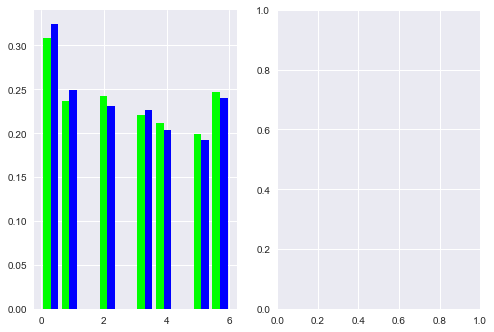

In [39]:
fig, axes = plt.subplots(1, 2)


x = [auctions.loc[auctions['sold_state']==1,'listingInfo.startTime.weekday'].values,\
     auctions.loc[auctions['sold_state']==0,'listingInfo.startTime.weekday'].values]
colors = ['lime', 'b']
axes[0].hist(x, normed=1, color=colors, label=['sold=0','sold=1']);

x = [auctions.loc[auctions['sold_state']==1,'listingInfo.startTime.hour'].values,\
     auctions.loc[auctions['sold_state']==0,'listingInfo.startTime.hour'].values]
# axes[1].hist(x, normed=1, color=colors, label=['sold=0','sold=1']);
axes[1].plot

plt.legend()

# sns.distplot(auctions.loc[auctions['sold_state']==1,'listingInfo.startTime.weekday'])
# sns.distplot(auctions.loc[auctions['sold_state']==0,'listingInfo.startTime.weekday'])

In [ ]:
# line plot
sold_by_hour = auctions.loc[auctions['sold_state']==1].groupby(by='listingInfo.startTime.hour').sum()['id']
unsold_by_hour = auctions.loc[auctions['sold_state']==0].groupby(by='listingInfo.startTime.hour').sum()['id']

sold_by_hour_df = pd.DataFrame(data=sold_by_hour.values, columns=['sold'], index=sold_by_hour.index)
unsold_by_hour_df = pd.DataFrame(data=unsold_by_hour.values, columns=['unsold'], index=unsold_by_hour.index)

listings_by_hour = pd.concat(objs=[sold_by_hour_df, unsold_by_hour_df], axis=1)

listings_by_hour['total'] = listings_by_hour['sold'] + listings_by_hour['unsold']

listings_by_hour['% sold'] = listings_by_hour['sold'] / listings_by_hour['total']
listings_by_hour['% unsold'] = listings_by_hour['unsold'] / listings_by_hour['total']

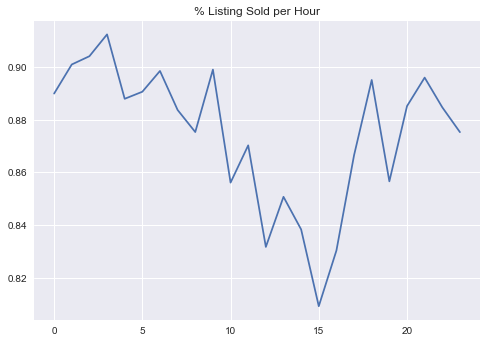

In [71]:
plt.plot(listings_by_hour['% sold'])
plt.title('% Listing Sold per Hour')

### Data Preprocessing

In [73]:
# Use startPrice, title (vectorized), conditionDisplayName (one-hot-encoded)
auction_condition_dummies = pd.get_dummies(data=auctions['condition.conditionDisplayName'])

start_price_series = auctions['startPrice']

titles = auctions['title']

sold = auctions['sold_state']

condition_combined = auctions['conditionCombined']

end_price = auctions['endPrice']

start_time_series = auctions['listingInfo.startTime']

end_time_series = auctions['listingInfo.endTime']

feedback_percent_series = pd.Series(auctions['sellerInfo.positiveFeedbackPercent'], name='feedback_percent')

top_rated_seller_series = pd.Series(auctions['sellerInfo.topRatedSeller'].apply(lambda x: 1 if x==True else 0), name='top_rated_seller')

expedited_shipping_series = pd.Series(auctions['shippingInfo.expeditedShipping'], name='expedited_shipping')

shipping_cost_series = pd.Series(auctions['shippingInfo.shippingServiceCost.value'], name='shipping_cost')

handling_time_series = pd.Series(auctions['shippingInfo.handlingTime'], name='handling_time')

one_day_shipping_series = pd.Series(auctions['shippingInfo.oneDayShippingAvailable'], name='one_day_shipping')

one_day_shipping_series = pd.Series(auctions['shippingInfo.oneDayShippingAvailable'], name='one_day_shipping')

returns_accepted_series = pd.Series(auctions['returnsAccepted'], name='returns_accepted')

hour = auctions['listingInfo.startTime.hour']

In [74]:
clean_titles = []
for i,title in enumerate(titles.values):
    if (i+1)%5000==0:
        print 'cleaning #{} out of {} documents'.format(i+1,len(condition_combined))
    clean_titles.append(clean_text(title))

clean_conditions = []
for i,cond in enumerate(condition_combined):
    if (i+1)%5000==0:
        print 'cleaning #{} out of {} documents'.format(i+1,len(condition_combined))
    clean_conditions.append(clean_text(cond))

cleaning #5000 out of 29961 documents
cleaning #10000 out of 29961 documents
cleaning #15000 out of 29961 documents
cleaning #20000 out of 29961 documents
cleaning #25000 out of 29961 documents
cleaning #5000 out of 29961 documents
cleaning #10000 out of 29961 documents
cleaning #15000 out of 29961 documents
cleaning #20000 out of 29961 documents


/Users/Naekid/anaconda3/envs/dsi/lib/python2.7/site-packages/bs4/__init__.py:219: UserWarning: "." looks like a filename, not markup. You shouldprobably open this file and pass the filehandle intoBeautiful Soup.
  'Beautiful Soup.' % markup)


cleaning #25000 out of 29961 documents


In [76]:
vectorizer = TfidfVectorizer(ngram_range = (1,2),
                             min_df=5,
                             analyzer='word',
                             stop_words=None,
                             max_features=10000,
                            )

titles_matrix = vectorizer.fit_transform(clean_titles)

import operator
# print sorted(vectorizer.vocabulary_.items(), key=operator.itemgetter(1), reverse=True)[:5]

titles_df = pd.DataFrame(titles_matrix.todense(), columns=vectorizer.vocabulary_.keys())

In [77]:
vectorizer = CountVectorizer(ngram_range = (1,2),
                             min_df=30,
                             analyzer='word',
                             stop_words=None,
                             max_features=5000,
                            )

conditions_matrix = vectorizer.fit_transform(clean_conditions)

import operator
# print 'most common condition grams:',sorted(vectorizer.vocabulary_.items(), key=operator.itemgetter(1), reverse=True)[:5]
# print 'least common condition grams:',sorted(vectorizer.vocabulary_.items(), key=operator.itemgetter(1), reverse=False)[:5]

conditions_df = pd.DataFrame(conditions_matrix.todense(), columns=vectorizer.vocabulary_.keys())

In [78]:
del clean_titles
del clean_conditions
del conditions_matrix
del titles_matrix

Create processed dataframe

In [87]:
data_frames_to_keep = [titles_df,\
                       conditions_df,\
                       auction_condition_dummies,\
                       feedback_percent_series,\
                       top_rated_seller_series,\
                       expedited_shipping_series,\
                       shipping_cost_series,\
                       handling_time_series,\
                       one_day_shipping_series,\
                       returns_accepted_series,\
                       start_price_series,\
                       hour,\
                       sold]

df_classification = pd.concat(data_frames_to_keep, axis=1)

In [88]:
# Impute missing values
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy='most_frequent', axis=0)
df_classification['shipping_cost'] = imputer.fit_transform(df_classification['shipping_cost'].values.reshape(-1,1))

df_classification['handling_time'] = imputer.fit_transform(df_classification['handling_time'].values.reshape(-1,1))

print 'Null Rows %:',np.sum(df_classification.isnull().sum())/df_classification.shape[0]

for dataframe in data_frames_to_keep:
    del dataframe

Null Rows %: 0


In [89]:
df_classification.head(2)

,z990 12,excellent cond,lumix digital,grip charger,medium format,270,275,kodak,af nikon,body read,cmos smart,package deal,card case,lens free,batteries strap,e6,slt a33,slt a35,zoom lense,fe fe,elph 170,fujifilm pro1,tz25,body working,12 megapixel,titanium,zoom mega,fuji fine,dsc f707,travel,...,photos hassle,scratches dents,cleaned,condition low,please read,shutter actuations,store returns,dent,operational,know,repair,warranty,ex,little use,For parts or not working,Manufacturer refurbished,New,New other (see details),Seller refurbished,Used,feedback_percent,top_rated_seller,expedited_shipping,shipping_cost,handling_time,one_day_shipping,returns_accepted,startPrice,listingInfo.startTime.hour,sold_state
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,91.7,0,1,0.0,2.0,0,1,399.0,18,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,100.0,0,1,0.0,3.0,0,0,300.0,23,1


### Train Test Split

In [82]:
X_class = df_classification.ix[:, :-1].values
y_class = df_classification.ix[:, -1].values
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, random_state=42, test_size=0.2)

In [83]:
del df_classification

### Modeling 


Baseline

With hour of day feature 

In [84]:
rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1)

rfc.fit(X_train_class, y_train_class)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [85]:
print 'Baseline Accuracy:',accuracy_score(y_test_class, np.ones(y_test_class.shape[0]))
print 'Model accuracy:',accuracy_score(y_test_class, rfc.predict(X_test_class))

Baseline Accuracy: 0.857667278492
Model accuracy: 0.90772567996


In [90]:
print 'top 5 features:'
feature_importances = sorted(zip(auctions.columns.tolist()[:-1], rfc.feature_importances_), key=lambda x: x[1], reverse=True)
sorted(zip(df_classification.columns.tolist()[:-1], rfc.feature_importances_), key=lambda x: x[1], reverse=True)[:5]

top 5 features:


[('startPrice', 0.063738503386308376),
 ('listingInfo.startTime.hour', 0.041149680519517423),
 ('shipping_cost', 0.02036953189404922),
 (u'255', 0.014619487225890893),
 ('handling_time', 0.011516121251740013)]

In [92]:
df_regression = pd.read_pickle('./pickles/df_regression_tfidf.p')

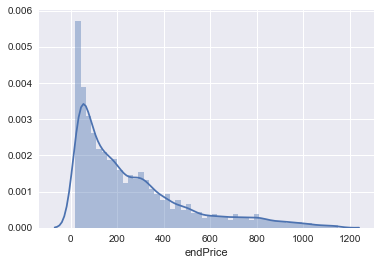

In [93]:
sns.distplot(df_regression['endPrice'])